Create a model to train and predict what type of Driver is... 

> remove normal class, in case there's bit of problems

In [1]:
# Importamos librerias esenciales
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Ignoramos warnings jeje
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importamos trainig dataset
df_train = pd.read_csv("./train_motion_data.csv")
df_train.head() 

FileNotFoundError: ignored

Checamos la correlación del training data para darnos una idea de sus diferencias.

In [ ]:
df_train.corr()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Timestamp
AccX,1.000000,0.207575,-0.044951,-0.099053,0.041181,-0.316195,0.040371
AccY,0.207575,1.000000,0.041521,-0.018746,0.004012,-0.041036,0.005101
AccZ,-0.044951,0.041521,1.000000,-0.042200,-0.012598,0.078577,-0.009431
GyroX,-0.099053,-0.018746,-0.042200,1.000000,0.209730,0.228621,-0.002978
GyroY,0.041181,0.004012,-0.012598,0.209730,1.000000,0.154064,0.005673
GyroZ,-0.316195,-0.041036,0.078577,0.228621,0.154064,1.000000,-0.031176
Timestamp,0.040371,0.005101,-0.009431,-0.002978,0.005673,-0.031176,1.000000


### Datos

Buscamos posibles datos nulos.


*spoilers:*
no hay

In [ ]:
df_train.isnull().sum()

AccX         0
AccY         0
AccZ         0
GyroX        0
GyroY        0
GyroZ        0
Class        0
Timestamp    0
dtype: int64

Generamos un pairplot para visualizar las variables que conoceremos como *X* que serán para clasificar la clase, la cual es la *y* de nuestros modelos.

Descubrimos que las clases, evidentemente estan esparcidas en uniformente por sus respectivas variaciones, siendo Agresivos, Normales y Lentos. Podemos reconocer que ciertos modelos pueden ser utiles que otros, los cuales serán comprobados durante este notebook.

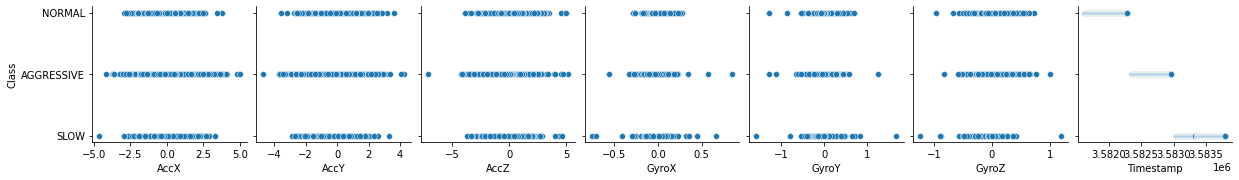

In [ ]:
sns.pairplot(
    df_train,
    x_vars = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'Timestamp'],
    y_vars = ['Class'],
)

Creamos un histograma de las clases para identificar la cantidad de cada una viendo esto que hay más lentos y los agresivos siendo la clase más pequeña.

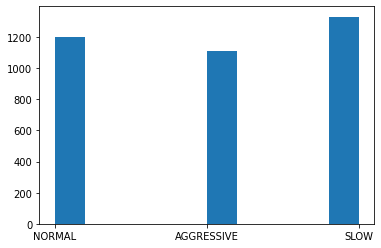

In [ ]:
plt.hist(df_train['Class'])
plt.show()

Reemplazo de tipo de dato para columna Clase: str -> int

In [ ]:
df_train = df_train.replace({"Class":  {"SLOW":1, "NORMAL":2, "AGGRESSIVE":3} })

Se intento una normalizacion para obtener un rango de datos más conciso y obtener un resultado más preciso.

Al final se decidio descartar esta opción ya que al normalizar los datos y correr los modelos, seguian dando mismos resultados como si estos no fueran normalizados a lo igual que si lo fueran.

In [ ]:
# (valores - promedio) / desviacion estandar : NORMALIZACION
# df_train.iloc[:, 0:6] = (df_train.iloc[:, 0:6]-df_train.iloc[:, 0:6].mean()) / df_train.iloc[0, 0:6].std()
# df_train.iloc[:, 7:] = (df_train.iloc[:, 7:]-df_train.iloc[:, 7:].mean()) / df_train.iloc[:, 7:].std()
# df_train

Generamos valores *X* y *y* para el dataset de training, los que se usarán para cada modelo.

In [ ]:
#dfX  = pd.DataFrame(df_train[["AccX", "AccY", "GyroX"]].values)
dfX  = pd.DataFrame(df_train[["AccX", "AccY", "GyroX",	"GyroY",	"GyroZ"]].values)
dfy  = pd.DataFrame(df_train[['Class']].values)

Se gráfico un heatmap de la correlación de las columnas para poder ver como estas son diferentes. 

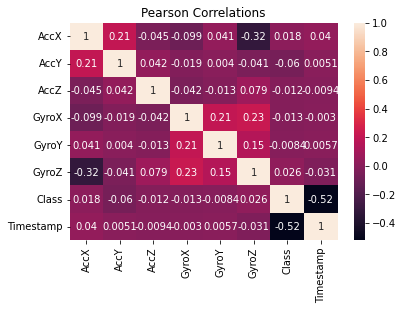

In [ ]:
ax = sns.heatmap(df_train.corr(), annot=True).set(title='Pearson Correlations');

Creamos una variable DataFrame para el dataset del test y reemplazamos las variables de Clase a *int* como con el training data.

In [ ]:
# Obtaining test data
df_test = pd.read_csv("./test_motion_data.csv")
df_test = df_test.replace({"Class":  {"SLOW":1, "NORMAL":2, "AGGRESSIVE":3} })
df_test.head(3)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp
0,0.758194,-0.217791,0.457263,0.000000,0.000000,0.000000,3,818922
1,0.667560,-0.038610,0.231416,-0.054367,-0.007712,0.225257,3,818923
2,2.724449,-7.584121,2.390926,0.023824,0.013668,-0.038026,3,818923


Creamos variables *X* y *y* también para el dataset de testing que serán utilizados para poder verificar el accuracy score de nuestros modelos.

In [ ]:
# dfX_test  = pd.DataFrame(df_test[["AccX", "AccY", "GyroX"]].values)
dfX_test  = pd.DataFrame(df_test[["AccX", "AccY", "GyroX",	"GyroY",	"GyroZ"]].values)
dfy_test  = pd.DataFrame(df_test[['Class']].values)

A lo igual que el training data, hicimos una normalización para el testing data, pero ya que recibiamos mismos valores decidimos descartarlos más comentarlos para futuras referencias.

In [ ]:
# (valores - promedio) / desviacion estandar : NORMALIZACION
# df_test.iloc[:, 0:6] = (df_test.iloc[:, 0:6]-df_test.iloc[:, 0:6].mean()) / df_test.iloc[0, 0:6].std()
# df_test.iloc[:, 7:] = (df_test.iloc[:, 7:]-df_test.iloc[:, 7:].mean()) / df_test.iloc[:, 7:].std()
# df_test

Queriendo probar posibles soluciones hicimos una división a la mitad del trainig data para ver si podriamos entrenarlo mejor, lo cual resulto con scores peores que los originales lo cual decidimos dejar esta opción. Igual elaboramos sus propias variables pero también fueron descartadas.

In [ ]:
# df_train2 = df_train.iloc[:1542]
# df_train2

In [ ]:
# dfX  = pd.DataFrame(df_train2[["AccX", "AccY", "GyroX",	"GyroY",	"GyroZ"]].values)
# dfy  = pd.DataFrame(df_train2[['Class']].values)

A continuación se mostrarán los tres modelos desarrollados estos siendo, Regresión Logstica, k Nearest Neighbor (kNN) y KMeans. Con el proposito de obtener un accuracy decente para poder clasificar que tipo de conductor hay en el testing data.

### Modelo de Regresión

In [ ]:
# importamos libreria de Regresión Logistica

from sklearn.linear_model import LogisticRegression

Implementamos la función de Regresión Logistica utilizando nuestros variables del training data y creamos el modelo, después elaboramos una predicción usando la variabla *X* del testing data para ver si funciona dicho modelo. 

Corremos un accuracy score y obtenemos un porcentaje de 45.6%

In [ ]:
# creamos modelo de Regresión

logreg_model = LogisticRegression(C=1e5, class_weight=None)
logreg_model.fit(dfX, dfy)

ypred = logreg_model.predict(dfX_test)

print("Exactitud del modelo: ", logreg_model.score(dfX_test, dfy_test))

Exactitud del modelo:  0.4571984435797665


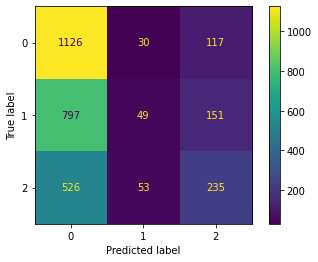

In [ ]:
# Importamos librerias para la matriz de confusión

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Desplegamos nuestra matriz y obtenemos resultados

CM = confusion_matrix(dfy_test, ypred)
CMNorm = ConfusionMatrixDisplay(confusion_matrix=CM)
CMNorm.plot()
plt.show()

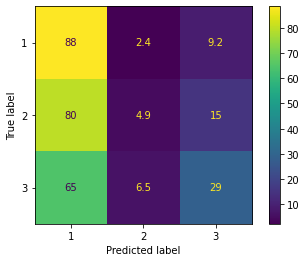

In [ ]:
# Elaboramos otra matriz pero normalizada a lo igual que con porcentaje a 100
CMNorm = confusion_matrix(dfy_test, ypred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=CMNorm*100, display_labels=logreg_model.classes_)
disp.plot()
plt.show()

Creamos un reporte de la clasificación utilizando como comparación las variables *y* del testing data y la predicción del modelo. 

Donde podemos ver como tenemos otra vez nuestro accuracy de 45.6%. Este modelo no es tan convicente ya que esta por debajo del 50% y puede llegar a fallar más que lograr lo esperado.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(dfy_test, ypred))

              precision    recall  f1-score   support

           1       0.46      0.88      0.61      1273
           2       0.37      0.05      0.09       997
           3       0.47      0.29      0.36       814

    accuracy                           0.46      3084
   macro avg       0.43      0.41      0.35      3084
weighted avg       0.43      0.46      0.37      3084



Para querer hacerlo más eficiente se utilizo el metódo de scaling en donde utilizamos los tres distintos metódos para poder compararlos y elegir el cual más sea eficiente y aceptarlo como nuestro nuevo accuracy.

In [ ]:
# Importamos librerias de scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score

In [ ]:
# Hacemos una copia del trainig dataset para nuestro modelo y no arruinar los datos originales.
df_model_logreg = df_train.copy()

**Standard Scaling**

Este metódo estandariza las variables eliminando la media y escalando a la varianza unitaria. 

Al correr este modelo reconocemos como hay un aumento de en el accuracy original, este siendo de 45.6% a uno de 46.2% 

In [ ]:
scaler = StandardScaler()

# Estandarizamos y transformamos las variables
features = [['AccX', 'AccY', 'GyroX', 'GyroY', 'GyroZ']]
for feature in features:
    df_model_logreg[feature] = scaler.fit_transform(df_model_logreg[feature])

#Creamos modelo de LR
log_reg = LogisticRegression(C=1e5)

#Creamos X y y variable
dfX = df_model_logreg[["AccX", "AccY", "GyroX",	"GyroY",	"GyroZ"]].values
dfy = df_model_logreg[['Class']].values

#Entrenamos el modelo
log_reg.fit(dfX, dfy)

#Hacemos la predicción
y_pred = log_reg.predict(dfX_test)

#Verificamos el nuevo accuracy
print(accuracy_score(dfy_test, y_pred))

0.46206225680933855


**Robust Scaling** 

Escala las variables utilizando estadísticas que sean robustas para los valores atípicos.

Este scaling method elimina la mediana y escala los datos de acuerdo con el rango de cuantiles (por defecto es IQR: Rango intercuartílico). El IQR es el rango entre el 1er cuartil (cuantil 25) y el 3er cuartil (cuantil 75).

Este tiene un resultado de 45.6% similar al accuracy inicial dejandolo como un modelo con scaling nulo para nuestro clasificador.

In [ ]:
scaler = RobustScaler()

# Estandarizamos y transformamos las variables
features = [['AccX', 'AccY', 'GyroX', 'GyroY', 'GyroZ']]
for feature in features:
    df_model_logreg[feature] = scaler.fit_transform(df_model_logreg[feature])

# Creamos modelo de LR
log_reg = LogisticRegression(C=1e5)

#Creamos X y y variable
dfX = df_model_logreg[["AccX", "AccY", "GyroX",	"GyroY",	"GyroZ"]].values
dfy = df_model_logreg[['Class']].values

#Entrenamos el modelo
log_reg.fit(dfX, dfy)

#Hacemos la predicción
y_pred = log_reg.predict(dfX_test)

#Verificamos el nuevo accuracy
print(accuracy_score(dfy_test, y_pred))

0.4565499351491569


**MinMaxScaling**

Transforma variables escalando cada una a un rango determinado.

Este estimador escala y traduce cada variable individualmente de tal manera que esté en el rango dado en el conjunto de entrenamiento, por ejemplo, entre cero y uno.

Este produce el peor resultado de todos, dando un porcentaje de 34.5%, 11% porciento menos del inicial.

In [ ]:
scaler = MinMaxScaler()

# Estandarizamos y transformamos las variables
features = [['AccX', 'AccY', 'GyroX', 'GyroY', 'GyroZ']]
for feature in features:
    df_model_logreg[feature] = scaler.fit_transform(df_model_logreg[feature])

#Creamos modelo de LR
log_reg = LogisticRegression(C=1e5)

#Creamos X y y variable
dfX = df_model_logreg[["AccX", "AccY", "GyroX",	"GyroY",	"GyroZ"]].values
dfy = df_model_logreg[['Class']].values

#Entrenamos el modelo
log_reg.fit(dfX, dfy)

#Hacemos la predicción
y_pred = log_reg.predict(dfX_test)

#Verificamos el nuevo accuracy
print(accuracy_score(dfy_test, y_pred))

0.3450064850843061


Finalmente decidimos optar este Modelo con el uso de Escalado Estandar para mejorar el accuracy de este mismo. 

Ya que nos da un mayor porcentaje pero no dando lo suficiente para poder llegar a un accuracy de 50%

> **Accuracy Final:** *46.2%*

### Modelo de KNN

Nuestro segundo modelo, es el de k Nearest Neighbor, en el que buscamos valores k dentro de

In [ ]:
# xnew = [-0.429366, 0.778989, 0.613423, -1.840191, 0.997252]

In [ ]:
# Importamos la función de kNN
from sklearn.neighbors import KNeighborsClassifier

Despues de importar la función, hacemos un modelo sencillo de kNN donde usamos la metrica eculideana e insertamos nuestro training data para luego prpedecir el testing data. 

Al finalizar este proceso corremos la puntuación de nuestro accuracy y vemos que tiene un porcentaje de 32.3%.

In [ ]:
# create model
kNN = KNeighborsClassifier(n_neighbors = 15, metric = "euclidean")

# fit the model for the trainig data
kNN.fit(dfX, dfy)

# make a prediction
ypred = kNN.predict(dfX_test)
ypred

array([3, 3, 3, ..., 3, 3, 3])

In [ ]:
print("Puntuación del Modelo:",kNN.score(dfX_test, dfy_test))

Puntuación del Modelo: 0.3239299610894942


Al ver que es un modelo no tan apropiado para nuestros datasets, decidimos visualizarlos igual como el modelo anterior y también recrear una estandarización para mejorar su puntuaje.

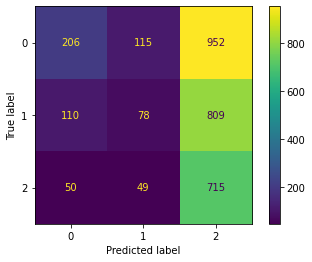

In [ ]:
CM = confusion_matrix(dfy_test, ypred)
CMNorm = ConfusionMatrixDisplay(confusion_matrix=CM)
CMNorm.plot()
plt.show()

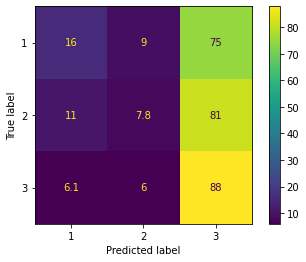

In [ ]:
CMNorm = confusion_matrix(dfy_test, ypred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=CMNorm*100, display_labels=kNN.classes_)
disp.plot()
plt.show()

In [ ]:
print(classification_report(dfy_test, ypred))

              precision    recall  f1-score   support

           1       0.56      0.16      0.25      1273
           2       0.32      0.08      0.13       997
           3       0.29      0.88      0.43       814

    accuracy                           0.32      3084
   macro avg       0.39      0.37      0.27      3084
weighted avg       0.41      0.32      0.26      3084



Otra solución de mejora es el uso de hiperparametros, pero al querer correrlo creo que la cantidad o el tipo de estos hizo que tuviera un falso en el resultado dando valores de utilidad no tan utiles. Por ello decidimos descartar esta opción,

In [ ]:
# # Usando hiperparametros
# from sklearn.model_selection import GridSearchCV

# leaf_size = list(range(1,100))
# n_neighbors = list(range(1,100))
# p=[1,2] # 1 = manhattan, 2 = euclidean

# # creamos diccionario
# hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

# # nuevo kNN
# kNN2 = KNeighborsClassifier()

# # uso de GridSearch?
# clf = GridSearchCV(kNN2, hyperparameters, cv=10)

# # fit model
# better_smarter_stronger_model = clf.fit(dfX, dfy)

# #Print The value of best Hyperparameters
# print('Best leaf_size:', better_smarter_stronger_model.best_estimator_.get_params()['leaf_size'])
# print('Best p:', better_smarter_stronger_model.best_estimator_.get_params()['p'])
# print('Best n_neighbors:', better_smarter_stronger_model.best_estimator_.get_params()['n_neighbors'])

In [ ]:
# elaboramos una copia del dataset para estandarizar
df_model = df_train.copy()

Standard Scaling

In [ ]:
scaler = StandardScaler()

features = [['AccX', 'AccY', 'GyroX', 'GyroY', 'GyroZ']]
for feature in features:
    df_model[feature] = scaler.fit_transform(df_model[feature])

#Create KNN Object
knn = KNeighborsClassifier(n_neighbors = 180, metric = "euclidean")

#Create x and y variable
dfX = df_model[["AccX", "AccY", "GyroX",	"GyroY",	"GyroZ"]].values
dfy = df_model[['Class']].values

#Training the model
knn.fit(dfX, dfy)

#Predict testing set
y_pred = knn.predict(dfX_test)

#Check performance using accuracy
print(accuracy_score(dfy_test, y_pred))

0.45492866407263294


Robust Scaling

In [ ]:
scaler = RobustScaler()

features = [['AccX', 'AccY', 'GyroX', 'GyroY', 'GyroZ']]
for feature in features:
    df_model[feature] = scaler.fit_transform(df_model[feature])

#Create KNN Object
knn = KNeighborsClassifier(n_neighbors = 180, metric = "euclidean")

#Create x and y variable
dfX = df_model[["AccX", "AccY", "GyroX",	"GyroY",	"GyroZ"]].values
dfy = df_model[['Class']].values

#Training the model
knn.fit(dfX, dfy)

#Predict testing set
y_pred = knn.predict(dfX_test)

#Check performance using accuracy
print(accuracy_score(dfy_test, y_pred))

0.46400778210116733


Min-Max Scaler

In [ ]:
scaler = MinMaxScaler()

features = [['AccX', 'AccY', 'GyroX', 'GyroY', 'GyroZ']]
for feature in features:
    df_model[feature] = scaler.fit_transform(df_model[feature])

#Create KNN Object
knn = KNeighborsClassifier(n_neighbors = 180, metric = "euclidean")

#Create x and y variable
dfX = df_model[["AccX", "AccY", "GyroX",	"GyroY",	"GyroZ"]].values
dfy = df_model[['Class']].values

#Training the model
knn.fit(dfX, dfy)

#Predict testing set
y_pred = knn.predict(dfX_test)

#Check performance using accuracy
print(accuracy_score(dfy_test, y_pred))

0.2778858625162127



Al utilizar los tres metódos, se puede ver un gran cambio en cada uno, sea para lo mejor o lo peor. Viendo que Robust y Standard tuvieron un aumento del 10% podemos reconocer que el uso de scaling en este modelo es útil. Al final nos quedamos con el Robust Scaling ya que es el mejor de las tres formas de scaling con un 1% mejor que el Standard Scaling.

> **Accuracy Final:** *46.34*

### Modelo Kmeans

In [ ]:
# Impprtamos libreria y función de KMeans
from sklearn.cluster import KMeans


KMeans lo utilizamos para poder buscar una clasificación de valores entre clusters, estos siendo grupos de varios datos y pueden representar varias cosas. En nuestro caso, los clusters serán nuestras clases.

Al generar el modelo necesitamos crear una columna cluster para agregarla al training dataset y poder obtener donde cada uno de los drivers pertenece.

In [ ]:
# creamos modelo kmeans y predecimos
km1 = KMeans(n_clusters=3, random_state=0)
km1.fit(dfX)

ypredict1 = km1.predict(dfX)

ypredict1

array([0, 1, 1, ..., 0, 0, 0], dtype=int32)

In [ ]:
ypredict1new = np.choose(ypredict1, [1, 2, 3]).astype(int)

ypredict1new

array([1, 2, 2, ..., 1, 1, 1])

In [ ]:
# df_train2['Cluster'] = ypredict1new

# df_train2

In [ ]:
# agregamos columna cluster en el dataset (esta randomizada no correcta)
df_train['Cluster'] = ypredict1new

df_train

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp,Cluster
0,0.000000,0.000000,0.000000,0.059407,-0.174707,0.101938,2,3581629,1
1,-1.624864,-1.082492,-0.204183,-0.028558,0.051313,0.135536,2,3581630,2
2,-0.594660,-0.122410,0.220502,-0.019395,-0.029322,0.087888,2,3581630,2
3,0.738478,-0.228456,0.667732,0.069791,-0.029932,0.054902,2,3581631,3
4,0.101741,0.777568,-0.066730,0.030696,-0.003665,0.054902,2,3581631,1
...,...,...,...,...,...,...,...,...,...
3639,0.915688,-2.017489,1.687505,0.450360,0.384845,-1.236468,1,3583789,3
3640,-1.934203,0.914925,-0.096013,0.321468,0.649350,-0.477162,1,3583790,1
3641,-0.222845,0.747304,-0.887430,0.361174,-0.406836,0.054291,1,3583790,1
3642,-0.349423,0.067261,0.394368,-0.132405,0.020159,-0.004963,1,3583791,1


In [ ]:
# buscamos la ubicación de cada cluster
km1.cluster_centers_

array([[0.46948251, 0.58864865, 0.47299794, 0.48459921, 0.51883195],
       [0.41893376, 0.4330916 , 0.47332688, 0.48495963, 0.52281007],
       [0.60925083, 0.52936191, 0.46280841, 0.48727246, 0.48872874]])

In [ ]:
# encontramos el margen de error de nuestro modelo, se podria decir que es el anti-accuracy
km1.inertia_

57.77992362509963

Al ver un error de 57.7% podemos entender que nuestro accuracy podría ser de 42.3% siendo este un modelo igual que los anteriores, bajo del 50%. 

Después de ver este fallo empezamos a buscar como estabilizar este error y hacemos una función para reconocer el margen de error y la ubicación del dato *k* dentro del cluster.

In [ ]:
sse = []

k_rng = range(3,30)

for k in k_rng:
  km = KMeans(n_clusters=k, random_state=2)
  km.fit_predict(dfX) # dfX is training data
  u = km.inertia_
  sse.append(u)
  print("The intertia for :", k, "Cluster is:", u)

# sse = []

# k_rng = range(1,180)

# for k in k_rng:
#   km = KMeans(n_clusters=k, random_state=2)
#   km = km.fit_predict(dfX) # dfX is training data
#   sse.append(km.inertia_)
#   print("The intertia for :", k, "Cluster is:", sse)

The intertia for : 3 Cluster is: 57.78909735546763
The intertia for : 4 Cluster is: 50.05001463369694
The intertia for : 5 Cluster is: 44.81645562841254
The intertia for : 6 Cluster is: 41.36285065301999
The intertia for : 7 Cluster is: 38.6786381883838
The intertia for : 8 Cluster is: 36.47106948267274
The intertia for : 9 Cluster is: 34.44904838800774
The intertia for : 10 Cluster is: 32.898945091191464
The intertia for : 11 Cluster is: 31.38488621623545
The intertia for : 12 Cluster is: 30.262636969088433
The intertia for : 13 Cluster is: 29.31943025938949
The intertia for : 14 Cluster is: 28.430393574417185
The intertia for : 15 Cluster is: 27.693844919783814
The intertia for : 16 Cluster is: 26.91326274865482
The intertia for : 17 Cluster is: 26.25744168822085
The intertia for : 18 Cluster is: 25.68375729469282
The intertia for : 19 Cluster is: 24.9888604817677
The intertia for : 20 Cluster is: 24.426652461154664
The intertia for : 21 Cluster is: 23.934477820623172
The intertia fo

Text(0.5, 1.0, 'Inertia Plot per k')

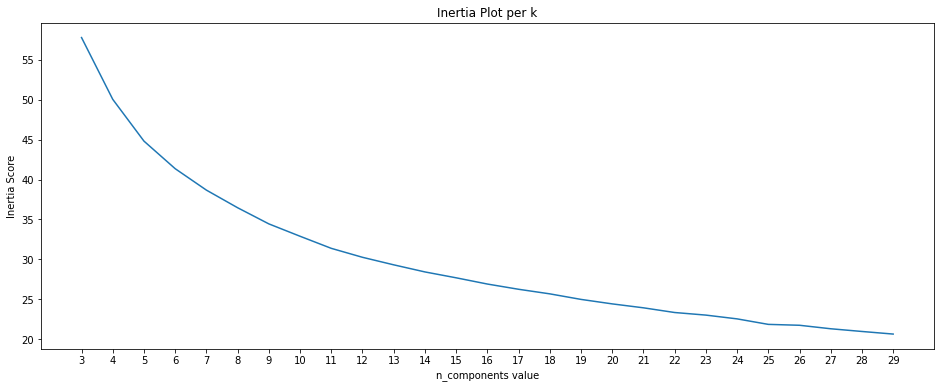

In [ ]:
#plt.plot(k_rng,sse)

#plt.show()

fig, (ax1) = plt.subplots(1, figsize=(16,6))
xx = np.arange(len(k_rng))
ax1.plot(xx, sse)
ax1.set_xticks(xx)
ax1.set_xticklabels(k_rng)
plt.xlabel('n_components value')
plt.ylabel('Inertia Score')
plt.title('Inertia Plot per k')

Al visualizar la gráfica podemos ver como con 30 datos vemos una estabilización del error hasta un 20.6%, dando una idea de que mientras mayor uso de datos, podemos concretar un modelo KMeans más estable.

# Hipotesis?
---

Alex:

Quiero reconocer primero que nada que el uso de las tres clases en estos modelos llega a dar unos puntuajes muy bajos de mi preferencia. Me gustaria pensar que quizas una mayor cantidad de datos podría ayudar crear un modelo más estable y probablemente mejor para que pueda clasificar con mayor facilidad y eficiencia. También, si tuvieramos más tiempo creo que podriamos buscar otros modelos de clasificación o funciones/herramientas que nos limpien y preparen mejor los datos para dar una solución más satisfactoria.